In [154]:
%matplotlib inline
#%config InlineBackend.figure_format='retina'

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import shmlast
from shmlast.last import MafParser
from shmlast import hits
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload

In [156]:
plt.style.use('seaborn-ticks')
mpl.rc('figure', figsize=(10,10))

In [157]:
reload(hits)

<module 'shmlast.hits' from '/work/shmlast/shmlast/hits.py'>

In [158]:
bh = hits.BestHits(comparison_cols=['E', 'EG2'])

In [166]:
tst_query_df = MafParser('data/crbl/sacPom.head.fa.renamed.pep.x.pep.head.fa.maf').read()
tst_db_df = MafParser('data/crbl/pep.head.fa.x.sacPom.head.fa.renamed.pep.maf').read()
tst_names = pd.read_csv('data/crbl/sacPom.head.fa.names.csv')
tst_recips = pd.read_csv('data/crbl/sacPom.head.fa.x.pep.head.fa.rbl.csv')

In [165]:
tst_names

,old_name,new_name
0,SPAC212.11|1|5662|-1|tlh1|I|protein_coding|Rec...,tr0
1,SPAC212.08c|11784|12994|1|SPAC212.08c|I|protei...,tr1


In [168]:
tst_recips

,EG2,s_aln_len,q_aln_len,s_name,q_start,s_start,E,score,q_strand,q_name,s_strand,s_len,q_len,bitscore,ID,q_frame
0,0.000000e+00,1887,1887,SPAC212.11|tlh1|I|RecQ,0,0,0.000000e+00,9911.0,+,tr0,+,1887,1888,4377.714719,0,1
1,3.300000e-184,278,278,SPAC212.08c|SPAC212.08c|I|S.,124,0,8.400000e-218,1509.0,+,tr1,+,278,403,669.316355,4,3


In [163]:
tst_query_df

,E,EG2,q_aln_len,q_len,q_name,q_start,q_strand,s_aln_len,s_len,s_name,s_start,s_strand,score,bitscore
0,0.000000e+00,0.000000e+00,1887,1888,tr0_1,0,+,1887,1887,SPAC212.11|tlh1|I|RecQ,0,+,9911.0,4377.714719
1,5.300000e-88,2.500000e-76,158,1888,tr0_1,1487,+,144,147,SPAC212.06c|SPAC212.06c|I|DNA,0,+,697.0,310.923178
2,1.000000e-04,1.300000e+08,67,404,tr1_5,92,+,67,278,SPAC212.08c|SPAC212.08c|I|S.,122,+,67.0,32.859507
3,9.100000e-04,1.100000e+09,57,404,tr1_6,56,+,59,278,SPAC212.08c|SPAC212.08c|I|S.,120,+,60.0,29.769910
4,8.400000e-218,3.300000e-184,278,403,tr1_3,124,+,278,278,SPAC212.08c|SPAC212.08c|I|S.,0,+,1509.0,669.316355
5,6.500000e-66,1.300000e-51,106,403,tr1_3,124,+,103,123,SPAC212.12|SPAC212.12|I|S.,0,+,511.0,228.828190
6,1.600000e-07,2.100000e+05,19,404,tr1_1,232,+,19,123,SPAC212.12|SPAC212.12|I|S.,104,+,88.0,42.128296


In [167]:
tst_db_df

,E,EG2,q_aln_len,q_len,q_name,q_start,q_strand,s_aln_len,s_len,s_name,s_start,s_strand,score,bitscore
0,1.300000e-221,3.300000e-184,278,278,SPAC212.08c|SPAC212.08c|I|S.,0,+,278,403,tr1_3,124,+,1509.0,669.316355
1,1.600000e-100,2.500000e-76,144,147,SPAC212.06c|SPAC212.06c|I|DNA,0,+,158,1888,tr0_1,1487,+,697.0,310.923178
2,1.500000e-72,1.300000e-51,103,123,SPAC212.12|SPAC212.12|I|S.,0,+,106,403,tr1_3,124,+,511.0,228.828190
3,1.200000e-07,2.100000e+05,19,123,SPAC212.12|SPAC212.12|I|S.,104,+,19,404,tr1_1,232,+,88.0,42.128296
4,3.700000e-04,1.300000e+08,67,278,SPAC212.08c|SPAC212.08c|I|S.,122,+,67,404,tr1_5,92,+,67.0,32.859507
5,0.000000e+00,0.000000e+00,1887,1887,SPAC212.11|tlh1|I|RecQ,0,+,1887,1888,tr0_1,0,+,9911.0,4377.714719


In [7]:
name_map = pd.read_csv('data/sacPom.cdna.fa.names.csv')

In [97]:
qvd_df = MafParser('data/sacPom.cdna.fa.renamed.pep.x.pep.fa.maf').read()

In [98]:
dvq_df = MafParser('data/pep.fa.x.sacPom.cdna.fa.renamed.pep.maf').read()

In [99]:
qvd_df[['qg_name', 'q_frame']] = qvd_df.q_name.str.partition('_')[[0,2]]
qvd_df.rename(columns={'q_name': 'translated_q_name',
                       'qg_name': 'q_name'},
              inplace=True)

In [133]:
qvd_df['ID'] = qvd_df.index

In [134]:
dvq_df[['sg_name', 'frame']] = dvq_df.s_name.str.partition('_')[[0,2]]
dvq_df.rename(columns={'s_name': 'translated_s_name',
                       'sg_name': 's_name'},
              inplace=True)

In [102]:
dvq_df['ID'] = dvq_df.index

In [117]:
rbh_df = bh.reciprocal_best_hits(qvd_df, dvq_df)

In [118]:
def scale_evalue(df, name='E'):
    df['E_s'] = df[name]
    df.loc[df['E_s'] == 0.0, 'E_s'] = 1e-300
    df['E_s'] = -np.log10(df['E_s'])

In [119]:
def generate_crbb_model(rbh_df):
    data = rbh_df[['s_aln_len', 'E']].rename(columns={'s_aln_len': 'length'})
    data.sort_values('length', inplace=True)
    
    scale_evalue(data)
    
    # create a DataFrame for the model, staring with the alignment lengths
    fit = pd.DataFrame(np.arange(10, data['length'].max()), columns=['center'], dtype=int)
    
    # create the bins
    fit['size'] = fit['center'] * 0.1
    fit.loc[fit['size'] < 5, 'size'] = 5
    fit['size'] = fit['size'].astype(int)
    fit['left'] = fit['center'] - fit['size']
    fit['right'] = fit['center'] + fit['size']
    
    # do the fitting: it's just a sliding window with an increasing size
    def bin_mean(fit_row, df):
        hits = df[(df['length'] >= fit_row.left) & (df['length'] < fit_row.right)]
        return hits['E_s'].mean()
    fit['fit'] = fit.apply(bin_mean, args=(data,), axis=1)
    
    return fit.dropna(), data

In [137]:
def filter_from_model(model_df, hits_df, rbh_df, scale=False):
    
    if scale:
        scale_evalue(hits_df) 
        
    comp_df = pd.merge(hits_df[hits_df['ID'].isin(rbh_df['ID']) == False], model_df, 
                       left_on='s_aln_len', right_on='center')
    
    return comp_df[comp_df['E_s'] >= comp_df['fit']]

In [135]:
fit, data = generate_crbb_model(rbh_df)

In [139]:
crbh_df = filter_from_model(fit, qvd_df, rbh_df, scale=True)

In [140]:
del crbh_df['center']
del crbh_df['left']
del crbh_df['right']
del crbh_df['fit']
del crbh_df['size']
del crbh_df['translated_q_name']

In [144]:
scale_evalue(rbh_df)

In [145]:
reciprocals = pd.concat([rbh_df, crbh_df], axis=0)

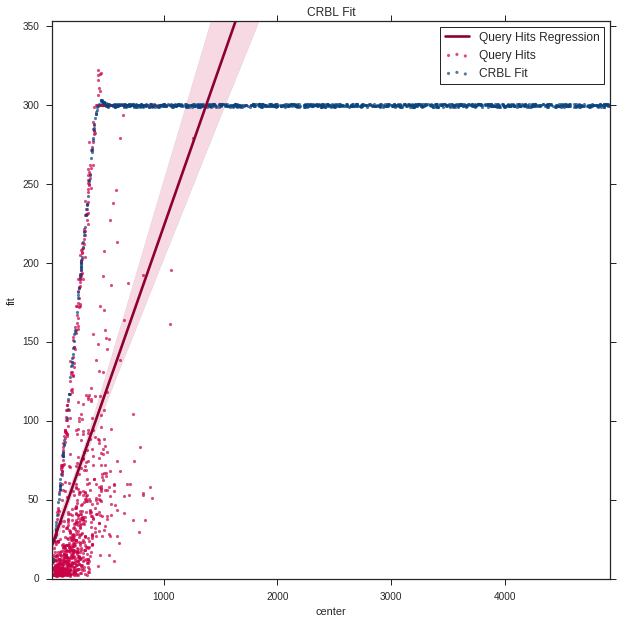

In [153]:
scatter_kws = {'s': 10, 'alpha':0.7}

scatter_kws['c'] = sns.xkcd_rgb['ruby']
scatter_kws['marker'] = 'o'
line_kws = {'c': sns.xkcd_rgb['red wine'], 'label':'Query Hits Regression'}
sns.regplot('s_aln_len', 'E_s', qvd_df.sample(1000), order=1, label='Query Hits',
            scatter_kws=scatter_kws, line_kws=line_kws, color=scatter_kws['c'], )

scatter_kws['c'] = sns.xkcd_rgb['twilight blue']
scatter_kws['marker'] = 's'
sns.regplot('center', 'fit', fit.reset_index().sample(1000), fit_reg=False, x_jitter=True, y_jitter=True, label='CRBL Fit',
            scatter_kws=scatter_kws, line_kws=line_kws)

leg = plt.legend(fontsize='medium', scatterpoints=3, frameon=True)
leg.get_frame().set_linewidth(1.0)
plt.xlim(fit.center.min(), fit.center.max())
plt.ylim(0, max(fit['fit'].max(), qvd_df['E'].max()) + 50)
plt.title('CRBL Fit')